# Analyse data for line loop navigation coming from the homecage 

In [1]:
%matplotlib inline

import numpy as np
import os
import sys
import re
import matplotlib.pyplot as plt
import scipy.stats as stt
import pandas as pd
from datetime import datetime, timedelta
from functools import partial
import matplotlib
import networkx as nx
import copy as cp
import seaborn
from scipy.ndimage import gaussian_filter1d
import seaborn as sns
from scipy.ndimage import gaussian_filter1d
import warnings

seaborn.set(font_scale=1.5,style='ticks')

In [2]:
#physical positions of the pokes
poke_pos = np.array([1,-1])*np.array([ [149,0],
         [68,19],[231,19],
       [0,62],[149,62],[298,62],
         [68,105],[231,105],
              [149,124]])

##  Main function to analyse probe trial performance

In [3]:
df = pd.DataFrame(columns=['subject','time','seq','graph_type','two_tasks','nRews','probe_dict'])

In [4]:
def get_experiment_name(line):
    return re.findall('Experiment name[\s] \: (.*)\n',line)[0]

def get_subject_name(line):
    return re.findall('Subject ID[\s]:[\s](.*)\n',line)[0]

def get_start_date(line):
    return re.findall('Start date[\s]:[\s](.*)\n',line)[0]

In [5]:
def get_probe_trial_performance_homecage(lines,fpath,MIN_REW_IN_SEQ=50):

    """ 
        Takes in lines output by pycontrol and returns a dict that contains probe trial
        performance for each transition
    
    
        Arguments:
        ===========================
        lines (list of str):             output of pycontrol
        
        Returns:
        ==========================
        all_info_dicts (list of dicts):  a list of dicts where each entry in the list
                                         is a dict containing whether probe trial\s were
                                         correct for each transition. If more than 1 graph
                                         was explored in a given session, then the performance
                                         then this list will have more than 1 dict in it. Other
                                         wise it will only have one
        
        
    """
    times = []
    probe_perf = []
    target_hist = []; probe_hist = []; poked_hist = []; dir_hist = []; seq_hist = []

    task_nums = []
    info_dict = {'fpath': fpath}
    probe_dict = {}
    all_info_dicts = [] #this is for when there are two tasks in one session
    seq = None
    task_number = None
    graph_type = None
    n_rewards = np.nan
    full_sequences = None
    #iterate over flines
    
    probe_start = -100000
    hasrunprobe = True
    
    
    try:
        probe_dur = float(eval(re.findall('Variables(.*)',lines[-1])[0])['probe_dur'])
    except IndexError:
        probe_dur = 2000.

    try:
        n_rew_tot = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
    except IndexError:
        n_rew_tot = 0
    rew_in_seq = 0
    if n_rew_tot>10:
        for ix,l_ in enumerate(lines[:-1]):


            #find basic task metadata
            if 'Subject ID' in l_: info_dict['subject'] = get_subject_name(l_)
            if 'Experiment name' in l_: info_dict['exp_name'] = get_experiment_name(l_)
            if 'Start date' in l_: info_dict['date'] = get_start_date(l_)

                

            if 'task_number' in l_:

                #if there is already one task then store the info for the
                #'completed' task here and perform some cleanup
                if len(task_nums)>0:
                    info_dict['seq'] = seq
                    info_dict['task_nr'] = task_number
                    info_dict['probe_dict'] = probe_dict.copy()
                    info_dict['len_seq'] = None if seq is None else len(seq)
                    info_dict['graph_type'] = graph_type
                    all_info_dicts.append(info_dict.copy())
                    info_dict = info_dict.copy()
                    del info_dict['probe_dict']
                    probe_dict = {}
                task_number = int(re.findall('task_number([0-9])',l_)[0])
                task_nums.append(task_number)

            #store the sequence that was explored
            if 'seq' in l_:
                seq = eval(re.findall('seq:(\[.*\])', l_)[0])

            if 'graph_type' in l_:
                graph_type = re.findall('graph_type:(.*)\n',l_)[0]
            #process the print-lines that describe the subjects behaviour
            
            
            if rew_in_seq>MIN_REW_IN_SEQ:
                if 'probe_start' in l_:
                    probe_start = float(re.findall('P ([0-9]*)',l_)[0])
                    hasrunprobe = False


            
            if 'TARGET:' in l_:  
                t_ = re.findall('P ([0-9]*) R',l_)[0]
                times.append(float(t_))
                probe = eval(re.findall('PROBE: (False|True)',l_)[0])
                target = int(re.findall('TARGET: ([0-9]*)',l_)[0])
                poked = int(re.findall('POKED: ([0-9]*)',l_)[0])
                direction = int(re.findall('DIR: (.*)',l_)[0])
                seq_ix = int(re.findall('SEQ_IX: ([0-9]*)',l_)[0])
                try:
                    rew_in_seq = int(re.findall('REW_IN_SEQ:([0-9]*)',l_)[0])
                except IndexError:
                    rew_in_seq = 99
                    
                if seq_hist:
                    if probe:  #if it is flagged as a probe trial
                        if not hasrunprobe:   #and this probe trial has not been counted
                            if rew_in_seq>MIN_REW_IN_SEQ:
                                
                                prev_target = None
                                pt_ctr = 1
                                while prev_target is None:
                                    if target_hist[-pt_ctr]!=target:
                                        prev_target = target_hist[-pt_ctr]
                                    pt_ctr+=1
                                    

                                if ((times[-1]-probe_start)<probe_dur):
                                    if poked==prev_target:
                                        pass
                                    else:
                                        hasrunprobe = True
                                        correct_poke = poked==target
                                        probe_perf.append(correct_poke)
                                        transition = str(prev_target) + '_' + str(target)

                                        if transition in probe_dict.keys():
                                            probe_dict[transition].append(correct_poke)
                                        else:
                                            probe_dict[transition] = [correct_poke]
                                else:
                                    #pass
                                    hasrunprobe = True
                                    correct_poke = False
                                    probe_perf.append(correct_poke)
                                    transition = str(prev_target) + '_' + str(target)

                                    if transition in probe_dict.keys():
                                        probe_dict[transition].append(correct_poke)
                                    else:
                                        probe_dict[transition] = [correct_poke]


                target_hist.append(target); probe_hist.append(probe); dir_hist.append(direction);
                poked_hist.append(poked); seq_hist.append(seq_ix)
        #print(len(probe_perf))
        try:
            n_rewards = float(eval(re.findall('Variables(.*)',lines[-1])[0])['n_rewards'])
            full_sequences = (eval(re.findall('Variables(.*)',lines[-1])[0])['sequences'])
        except IndexError:
            n_rewards = np.nan

        info_dict['seq'] = seq; info_dict['task_nr'] = task_number; info_dict['probe_dict'] = probe_dict.copy()
        info_dict['len_seq'] = None if seq is None else len(seq)
        info_dict['n_rewards'] = n_rewards
        info_dict['graph_type'] = graph_type
        info_dict['full_sequences'] = full_sequences
        all_info_dicts.append(info_dict)
    return all_info_dicts

In [6]:
def build_follow_the_light_probe_df(subject_folders):
    """
    Here we loop through the subject folders and get a list of all sessions
    that is annotated with some metadata
    
    Arguments:
    =========================================
    
    subject_folders (list): list of folders where each folder contains the
                            data files for one subject
                            
    
    """
    df = pd.DataFrame(columns=['subject','exp_name', 'date', 'seq', 'task_nr', 'probe_dict', 'len_seq','n_rewards','graph_type','sess_dur','full_sequence','fpath'])
    for ROOT in subject_folders:
        #print(ROOT)
        fs = [i for i in os.listdir(ROOT) if '_taskFile' not in i]
        probe_dict = {}
        for f_ in fs:
            if 'follow_the_light_2_graphs' in f_:
                #print(f_)
                fpath = os.path.join(ROOT,f_)
                with open(fpath,'r') as f:
                    lines = f.readlines()

                all_info_dict = get_probe_trial_performance_homecage(lines,fpath=fpath)
                #print(probe_dict)
                for i in all_info_dict:
                    df = df.append(i,ignore_index=True)
    return df, lines

In [7]:
def merge_probe_trial_dicts(x,only_last=None):
    """ 
    Function passed as argument to result of pandas groupby in
    order to merge the dicts by subject and task
    
    Arguments:
    =========================
    x: what is passed by agg
    
    only_last (int): only look at the last n probe trials for each transition
    """
    out = {}
    for d in x.dropna():
        for k,v in d.items():
            if k not in out.keys():
                out[k] = v.copy()
            else:
                out[k].extend(v)
                
    if only_last:
        for k,v in out.items():
            out[k] = v[-only_last:]
    return out


In [8]:
cmap_ = 'RdYlGn'
cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=0.6,clip=True),cmap=cmap_)


In [9]:
def make_plot(res_dict,mx=1,color='mean'):
    #plt.figure(figsize=(12,4))


#    mx = 1
    if color=='pval': cmap_ = 'RdYlGn_r'
    else: cmap_ = 'RdYlGn'
    cmap = matplotlib.cm.ScalarMappable(matplotlib.colors.Normalize(vmin=0,vmax=mx,clip=True),cmap=cmap_)

    G0 = nx.DiGraph()
    G0.add_nodes_from(range(9),pos=np.array([1,-1])*poke_pos,color='.3')
    nx.draw(G0,pos=poke_pos,alpha=.2,node_color='.3')


    G = nx.DiGraph()
    for k,v in res_dict.items():
        if color=='pval':
            c = stt.binom_test(np.sum(v),len(v),p=1/8.,alternative='greater')
        else:
            c= np.mean(v)
        G.add_edge(int(k[0]),int(k[-1]),color=cmap.to_rgba(c))

    colors = nx.get_edge_attributes(G,'color')

    nx.draw(G,
            pos=poke_pos,edge_color=np.array(list(colors.values())),
            node_color='.3',
            node_size=512,
            connectionstyle="arc3,rad=-0.1",
            width=3
    )
    #plt.colorbar()

In [10]:
def get_all_transition(seq,graph_type):
    """
    What is says on the tin. Returns a list of strings describing transitions that
    is analogous to what is stored in dataframe obtained by running build_df
    """
    all_transitions = []
    lseq = len(seq)
    if graph_type=='line': s2 = seq[:-1]
    else: s2 = seq
    for kk,pk in enumerate(s2):
        #print(1)
        all_transitions.append(str(pk) + '_' + str(seq[(kk+1)%lseq]))
        if graph_type=='line':
            all_transitions.append(str(seq[(kk+1)%lseq]) + '_' + str(pk))

    if graph_type=='loop':
        for kk,pk in enumerate(s2[::-1]):
            all_transitions.append(str(pk) + '_' + str(seq[::-1][(kk+1)%lseq]))
    return all_transitions

In [33]:
figure_path = '/Users/joshuakeeling/Documents/Python/Project/Figures'

def save_figure(name, base_path=figure_path):
    plt.rcParams['pdf.fonttype'] = 42
    plt.savefig(os.path.join(base_path, f'{name}.png'), 
                bbox_inches='tight', transparent=True)

In [42]:
from matplotlib import rcParams

params = {'legend.fontsize': 'xx-large',
         'axes.labelsize': 'xx-large',
         'axes.titlesize':'xx-large',
         'xtick.labelsize':'xx-large',
         'ytick.labelsize':'xx-large'}

plt.rc("axes.spines", top=False, right=False) # despine

COLORS = [
'#228E5E', # Hit green
'#DB3713', # Miss red
]

## MAKE THE FONT SIZE 20 or 21
rcParams['font.family'] = 'sans-serif'
rcParams['font.sans-serif'] = ['Arial']
rcParams['font.size'] = 14


rcParams.update(params)


# Run analysis

In [13]:
all_mice_csv = pd.read_csv('/Users/joshuakeeling/Dropbox/pyhomecage/mice/mice.csv')


In [14]:
all_data = []
for ix,row in all_mice_csv.iterrows():
    if 'ec_lineloop' in row['Experiment'] and not pd.isnull(row['set_variables']):
        try:
            tmp = [row['Mouse_ID'],
                   eval(eval(row['set_variables'])['v.len_seqs'])]
            all_data.append(tmp)
        except:
            print("error in:",row['Mouse_ID'])
            pass

error in: C00499495_2


In [15]:
all_data

[['C00494062_1', [9, 9]],
 ['C00494062_2', [9, 9]],
 ['C00494062_3', [9, 9]],
 ['C00494062_4', [9, 9]],
 ['C00494062_5', [9, 9]],
 ['C00499495_1', [9, 9]],
 ['C00499495_3', [9, 9]],
 ['C00499495_4', [9, 9]],
 ['C00499495_5', [9, 9]],
 ['C00499495_6', [9, 9]]]

In [16]:
np.mean([i[1] for i in all_data],axis=0)

array([9., 9.])

In [17]:
experiment_folders = ['/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_1/',
                     '/Users/joshuakeeling/Dropbox/pyhomecage/data/ec_lineloop_2/']

subject_folders = []
for ef in experiment_folders:
    sf1 = os.listdir(ef)
    
    for sf_ in sf1:
        sf = os.path.join(ef,sf_)
        #print(sf)
        #if sf=='/Users/yves/Downloads/ec_lineloop_2/.DS_Store':
        #|print('.DS' in sf)
        if not ('.DS' in sf):
            fold2 = [i for i in os.listdir(sf) if '.DS' not in i][0]
            subject_folders.append(os.path.join(sf,fold2))


In [18]:
df,lines = build_follow_the_light_probe_df(subject_folders)
df['date'] = pd.to_datetime(df['date'])
df = df.loc[df['n_rewards']>1]
df = df.sort_values('date')
if 'old_df' not in locals():
    old_df = cp.deepcopy(df)
    
df.to_csv('tmp.pd')

In [21]:
ROOT_dir = '/Users/joshuakeeling/Dropbox/pyhomecage/mice/'
mouse_fs = [os.path.join(ROOT_dir,i) for i in os.listdir(ROOT_dir) if 'mice' not in i]

subjects_w = []
for i in os.listdir(ROOT_dir):
    if 'mice' not in i:
        subject = i.split('.')[0] 
        subjects_w.append(subject)

dfs = []
for filename,subject in zip(mouse_fs[4:],subjects_w[4:]):
    df_ind = pd.read_csv(filename)
    df_ind['subject']=subject
    dfs.append(df_ind)

df_weights = pd.concat(dfs, ignore_index=True)
df_weights=df_weights.drop(['Unnamed: 0','RUN_ERROR','data_path','Variables'], axis=1)
df_weights['entry_time'] = pd.to_datetime(df_weights['entry_time'])
df_weights['exit_time'] = pd.to_datetime(df_weights['exit_time'])

In [22]:
out = df_weights.loc[df_weights['entry_time'].isin(df['date'].values)]

out2 = df.loc[df['date'].isin(out['entry_time'].values)]

df = out2.drop(['sess_dur','fpath'],axis=1)
out = out.sort_values('entry_time')
df= df.sort_values('date')

KeyError: "['sess_dur' 'fpath'] not found in axis"

In [23]:
df['exit_time']=out['exit_time'].values
df['weight']=out['weight'].values


# Plot basic visition stuff

In [24]:
# df_nr = df.copy()[df['date']>(datetime.now()-timedelta(days=100))]
start_date = '2021-05-10'
end_date = datetime.now()

df_nr = df.copy()[(df['date'] > start_date) & (df['date'] <= end_date)]


grouped_by_day = df_nr.groupby([pd.Grouper(key='date',freq='D'),'subject'])
gbd_sum =grouped_by_day['n_rewards'].sum()
gbd_dfs = gbd_sum.reset_index()

gbd_mean =grouped_by_day['n_rewards'].mean()
gbd_dfm = gbd_mean.reset_index()

gbd_num =grouped_by_day['n_rewards'].count()
gbd_dfn = gbd_num.reset_index()


#gbd_sum.add_suffix('_Count').reset_index()

In [25]:
subjects_a = ['C00494062_1', 'C00494062_2', 'C00494062_3', 
              'C00494062_4','C00494062_5']
subjects_b = ['C00499495_1', 'C00499495_3', 'C00499495_4',
              'C00499495_5', 'C00499495_6']

all_subjects = [subjects_a,subjects_b]

In [26]:
## This gives the mean where a power of 0 is awarded to mice that have completed the sessions
#change "arr = np.append(arr,[0]*(maxlen - len(arr)))" to have NaN instead of 0 for other plot

def ladder_plot(mice_dicts, color=0, label=None):
    length_arrs = []
    for subjects in all_subjects:
        power_arrs.append(get_power_arr(mouse_dict['runs']))

    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((maxlen, len(power_arrs)))

    for i, arr in enumerate(power_arrs):
        arr = np.append(arr,[0]*(maxlen - len(arr)))
        tomean[:,i] = arr

    meaned = np.nanmean(tomean,1)
    plt.plot(meaned, color=sns.color_palette()[color], label=label)
    for arr in power_arrs:
        plt.plot(arr, color=sns.color_palette()[color], alpha=0.2)

In [27]:
def get_progression(subj_groups):
    #outputs array of shape(#groups,#subj_in_group,#tasks)
    
    subj_groups = all_subjects
    raw_pr = np.empty((2,5,2),object) #prog in length w sessions
    len_pr = np.zeros((2,5,2),object)
    rew_pr = np.zeros((2,5,2),object)
    to_9 = np.zeros((2,5,2),object) #rew to criterion
    to_9s = np.zeros((2,5,2),object) #sess to criterion
    for indx, subj_group in enumerate(subj_groups):
        for indxx, subject in enumerate(subj_group):
            for task_nr in [0,1]:
                #Get trial number of progression
                raw = df[(df['subject']==subject)&(df['task_nr']==task_nr)]['len_seq'].values
                raw=np.where(raw==None,3,raw) #check this!
                raw_pr[indx][indxx][task_nr]=raw
                len_pr[indx][indxx][task_nr]=(np.append(np.where(raw[:-1] < raw[1:])[0],len(raw)-1))
                rew_pr[indx][indxx][task_nr]=(df[(df['subject']==subject)&(df['task_nr']==task_nr)]\
                                       ['n_rewards'].cumsum().values)
                to_9[indx][indxx][task_nr]=(df[(df['subject']==subject)&(df['task_nr']==task_nr)]\
                                       ['n_rewards'].cumsum().values[len_pr[indx][indxx][task_nr][-2]])
                to_9s[indx][indxx][task_nr]=np.where(raw[:-1] < raw[1:])[0][-1]

    return(raw_pr,len_pr,rew_pr,to_9,to_9s)

In [28]:
def ladder_plot_tsk(raw_pr,group_nr,label=None):
    temp = []
    for ii in np.arange(np.shape(raw_pr)[1]):
        for iii in np.arange(np.shape(raw_pr)[2]):
            plt.plot(raw_pr[iii][ii][group_nr], color=sns.color_palette()[group_nr], alpha=0.2)
            temp.append(raw_pr[iii][ii][group_nr])
    
    power_arrs = temp
    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((maxlen, len(power_arrs)))
    for i, arr in enumerate(power_arrs):
            arr = np.append(arr,[9]*(maxlen - len(arr)))
            tomean[:,i] = arr
    meaned = np.nanmean(tomean,1)
    plt.plot(meaned, color=sns.color_palette()[group_nr], label=label)

In [29]:
def ladder_plot_grp(raw_pr,group_nr,label=None):
    temp = []
    for ii in np.arange(np.shape(raw_pr)[1]):
        for iii in np.arange(np.shape(raw_pr)[2]):
            plt.plot(raw_pr[group_nr][ii][iii], color=sns.color_palette()[group_nr], alpha=0.2)
            temp.append(raw_pr[group_nr][ii][iii])
    
    power_arrs = temp
    maxlen =  max([len(a) for a in power_arrs]) 
    tomean = np.zeros((maxlen, len(power_arrs)))
    for i, arr in enumerate(power_arrs):
            arr = np.append(arr,[9]*(maxlen - len(arr)))
            tomean[:,i] = arr
    meaned = np.nanmean(tomean,1)
    plt.plot(meaned, color=sns.color_palette()[group_nr], label=label)

In [30]:
def ladder_plot_rew_grp(raw_pr,rew_pr,group_nr,label=None):
    temp = []
    for ii in np.arange(np.shape(raw_pr)[1]):
        for iii in np.arange(np.shape(raw_pr)[2]):
            plt.plot(rew_pr[group_nr][ii][iii],raw_pr[group_nr][ii][iii], 
                     color=sns.color_palette()[group_nr], alpha=0.8)
            temp.append(raw_pr[group_nr][ii][iii])
            
    #plt.plot(meaned, color=sns.color_palette()[group_nr], label=label)

In [31]:
nr_medians_a = []
nr_medians_b = []

for subject in subjects_a:
    median = gbd_dfs[gbd_dfs['subject']==subject]['n_rewards'].median()
    nr_medians_a.append(median)
    
for subject in subjects_b:
    median = gbd_dfs[gbd_dfs['subject']==subject]['n_rewards'].median()
    nr_medians_b.append(median)

print(np.mean(nr_medians_a),np.mean(nr_medians_b))

1235.6 665.3


10.7 15.2
!!!!significant!!!!


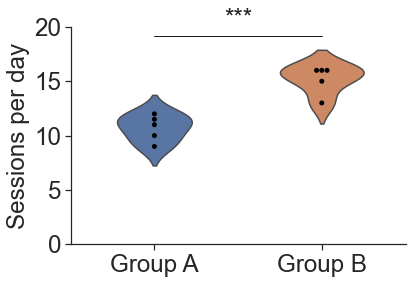

In [44]:
ns_medians_a = []
ns_medians_b = []

figure(figsize=(6,4))

for subject in subjects_a:
    median = gbd_dfn[gbd_dfn['subject']==subject]['n_rewards'].median()
    ns_medians_a.append(median)
    
for subject in subjects_b:
    median = gbd_dfn[gbd_dfn['subject']==subject]['n_rewards'].median()
    ns_medians_b.append(median)

print(np.mean(ns_medians_a),np.mean(ns_medians_b))

a = ns_medians_a
b = ns_medians_b

if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")
    
labels = ["Group A", "Group B"]
x = [a, b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Sessions per day')
ax.set_ylim(0,20)
from matplotlib.pyplot import figure

save_figure('AvsB sess per day')

In [45]:
w_medians_a = []
w_medians_b = []

for subject in subjects_a:
    median = df[df['subject']==subject]['weight'].median()
    w_medians_a.append(median)
    
for subject in subjects_b:
    median = df[df['subject']==subject]['weight'].median()
    w_medians_b.append(median)


print(np.mean(w_medians_a),np.mean(w_medians_b))

26.702204000000002 26.994231000000003


---- 
 No sig dif 
----


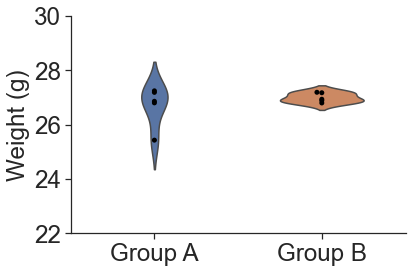

In [49]:
a = w_medians_a
b = w_medians_b
figure(figsize=(6,4))
if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")
    
labels = ["Group A", "Group B"]
x = [w_medians_a, w_medians_b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Weight (g)')
ax.set_ylim(22,30)
save_figure('AvsB Weight')

/opt/anaconda3/lib/python3.8/site-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


corrcoef is  -0.39669624039187784
p-value is  0.2563756594446344


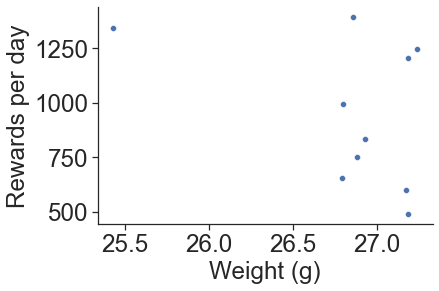

In [50]:
x = np.concatenate((w_medians_a,w_medians_b))
y = np.concatenate((nr_medians_a,nr_medians_b))
# y = np.concatenate((np.mean(to_9s,axis=2))) #to get sessions to criterion


ax = sns.scatterplot(x,y)
ax.set_ylabel('Rewards per day')
ax.set_xlabel('Weight (g)')

save_figure("Rewards by weight")

stt.pearsonr(x,y)
print("corrcoef is ",stt.pearsonr(x,y)[0])
print("p-value is ",stt.pearsonr(x,y)[1])

!!!!significant!!!!


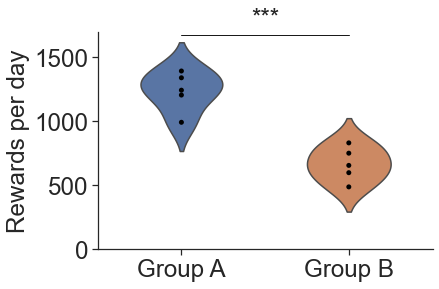

In [55]:
a = nr_medians_a
b = nr_medians_b
figure(figsize=(6,4))
if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")

labels = ["Group A", "Group B"]
x = [nr_medians_a, nr_medians_b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Rewards per day')
ax.set_ylim(0,1700)
save_figure('AvsB rew per day')

!!!!significant!!!!


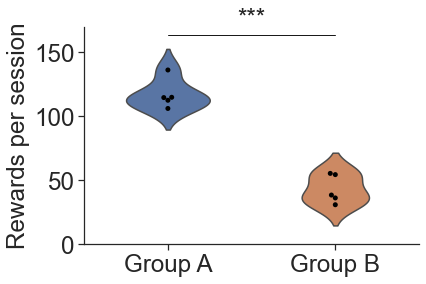

In [58]:
rew_sess = np.zeros((2,5))
figure(figsize=(6,4))
for indx, subject_group in enumerate(all_subjects):
    for indxx,subject in enumerate(subject_group):
        n_rew = df[df['subject']==subject]['n_rewards'].sum()
        n_sess = df[df['subject']==subject]['n_rewards'].count()
        rew_sess[indx,indxx] = n_rew/n_sess 

a = rew_sess[0]
b = rew_sess[1]


if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(a)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")

labels = ["Group A", "Group B"]
x = [a, b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylim(0,170)
ax.set_ylabel('Rewards per session')
save_figure('AvsB rew per session')

In [62]:
raw_pr,len_pr,rew_pr,to_9,to_9s = get_progression(all_subjects)

!!!!significant!!!!


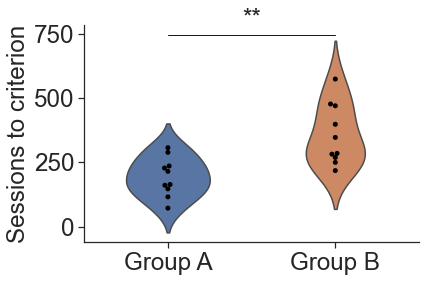

In [63]:
a = np.hstack(to_9s[0])
b = np.hstack(to_9s[1])
figure(figsize=(6,4))
if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.3
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.3
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.3
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")

labels = ["Group A", "Group B"]
x = [a, b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Sessions to criterion')
save_figure('AvsB sess to criterion')

---- 
 No sig dif 
----


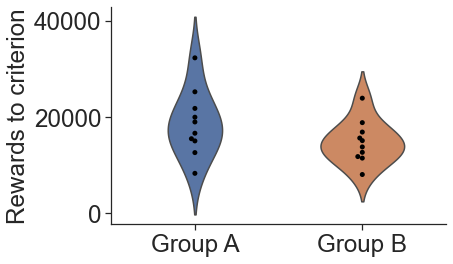

In [64]:
a = np.hstack(to_9[0])
b = np.hstack(to_9[1])
figure(figsize=(6,4))
if stt.ttest_ind(a,b)[1] < 0.001:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='***',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.01:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='**',ha='center',size='xx-large')
elif stt.ttest_rel(a,b)[1] < 0.05:
    print("!!!!significant!!!!")
    sign_height = np.max(b)*1.2
    plt.plot([0,0,1,1], [sign_height]*4, linewidth=1, color='k')
    plt.text(0.5,sign_height*1.05,s='*',ha='center',size='xx-large')
else:print("---- \n No sig dif \n----")
    
labels = ["Group A", "Group B"]
x = [a, b]
ax = sns.swarmplot(data = x, color = 'black' )
ax = sns.violinplot(data = x, inner = None, width = 0.5)
ax.set_xticklabels(labels)
ax.set_ylabel('Rewards to criterion')
save_figure('AvsB rew to criterion')

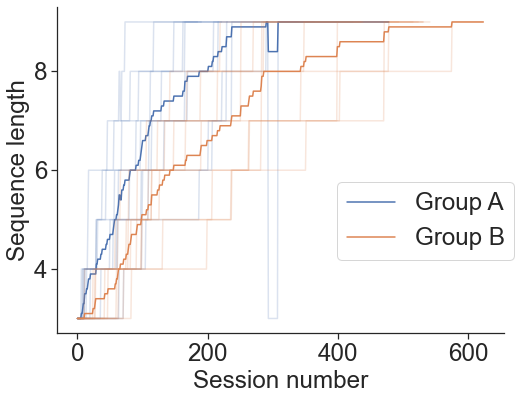

In [124]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                     
figure(figsize=(8,6))
ladder_plot_grp(raw_pr,0,label='Group A')
ladder_plot_grp(raw_pr,1,label='Group B')

plt.xlabel('Session number')
plt.ylabel('Sequence length')
plt.legend(bbox_to_anchor=(0.6, 0.5))
sns.despine()
save_figure('Ladder AvsB')

No handles with labels found to put in legend.


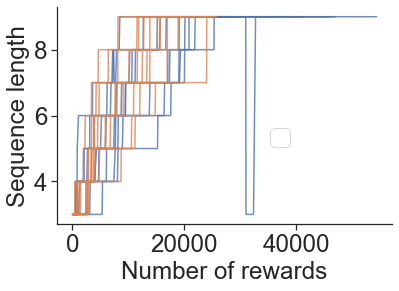

In [45]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                     
ladder_plot_rew_grp(raw_pr,rew_pr,0,label='Group A')
ladder_plot_rew_grp(raw_pr,rew_pr,1,label='Group B')

plt.xlabel('Number of rewards')
plt.ylabel('Sequence length')
plt.legend(bbox_to_anchor=(0.6, 0.5))
sns.despine()
#save_figure('Ladder rew AvsB')

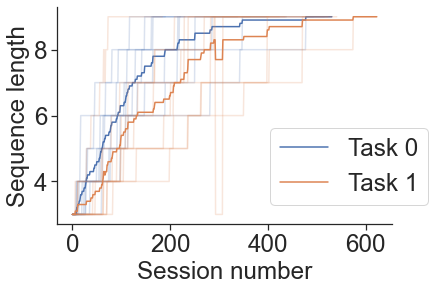

In [46]:
np.warnings.filterwarnings('ignore', category=np.VisibleDeprecationWarning)                     
ladder_plot_tsk(raw_pr,0,label='Task 0')
ladder_plot_tsk(raw_pr,1,label='Task 1')

plt.xlabel('Session number')
plt.ylabel('Sequence length')
plt.legend(bbox_to_anchor=(0.6, 0.5))
sns.despine()
#save_figure('Ladder 0vs1')

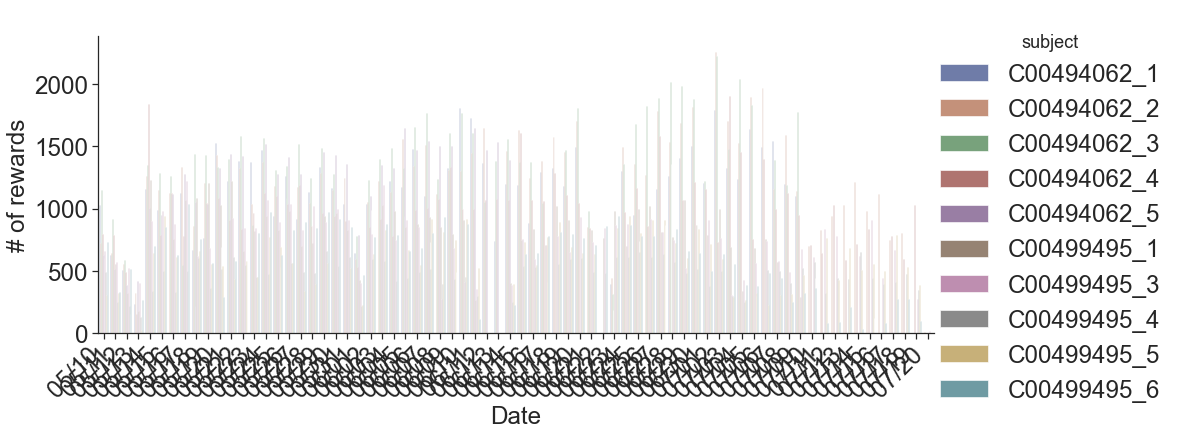

In [275]:
##Plots number of rewards over a given number of days 

#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfs, kind="bar",
    x="date", y="n_rewards", hue="subject",
    ci="sd", palette="dark", alpha=.6, height=5, # make the plot 5 units high
    aspect=3
)

#g.despine(left=True)
g.set_axis_labels("Date", "# of rewards")
x_dates = gbd_dfs['date'].dt.strftime('%m/%d').sort_values().unique()
_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')

#g.legend.set_title("")


<ipython-input-276-30735dfb875a>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  _ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')


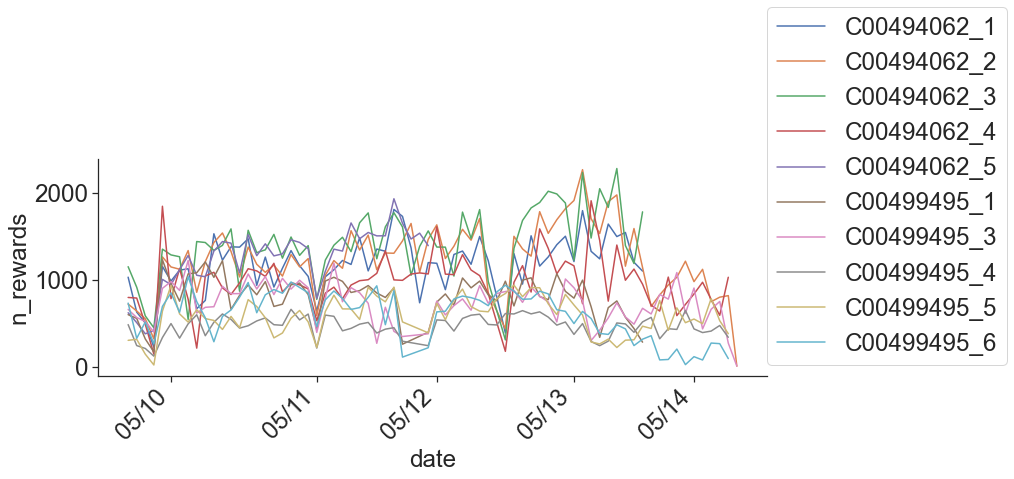

In [276]:
#Dates are labelled wrong!!!!!!

plt.figure(figsize=(12,4))
g = seaborn.lineplot(data=gbd_dfs,y='n_rewards',x='date',hue='subject')

#g.set_axis_labels("Date", "# of rewards")

x_dates = gbd_dfs['date'].dt.strftime('%m/%d').sort_values().unique()
_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')
seaborn.despine()
legend = plt.gca().legend(loc=(1,.05))
#for l in legend.get_texts():
##    l.set_text(datetime.strptime(l.get_text()[:10],'%Y-%m-%d').strftime('%d/%m'))
##g.legend.set_title("")


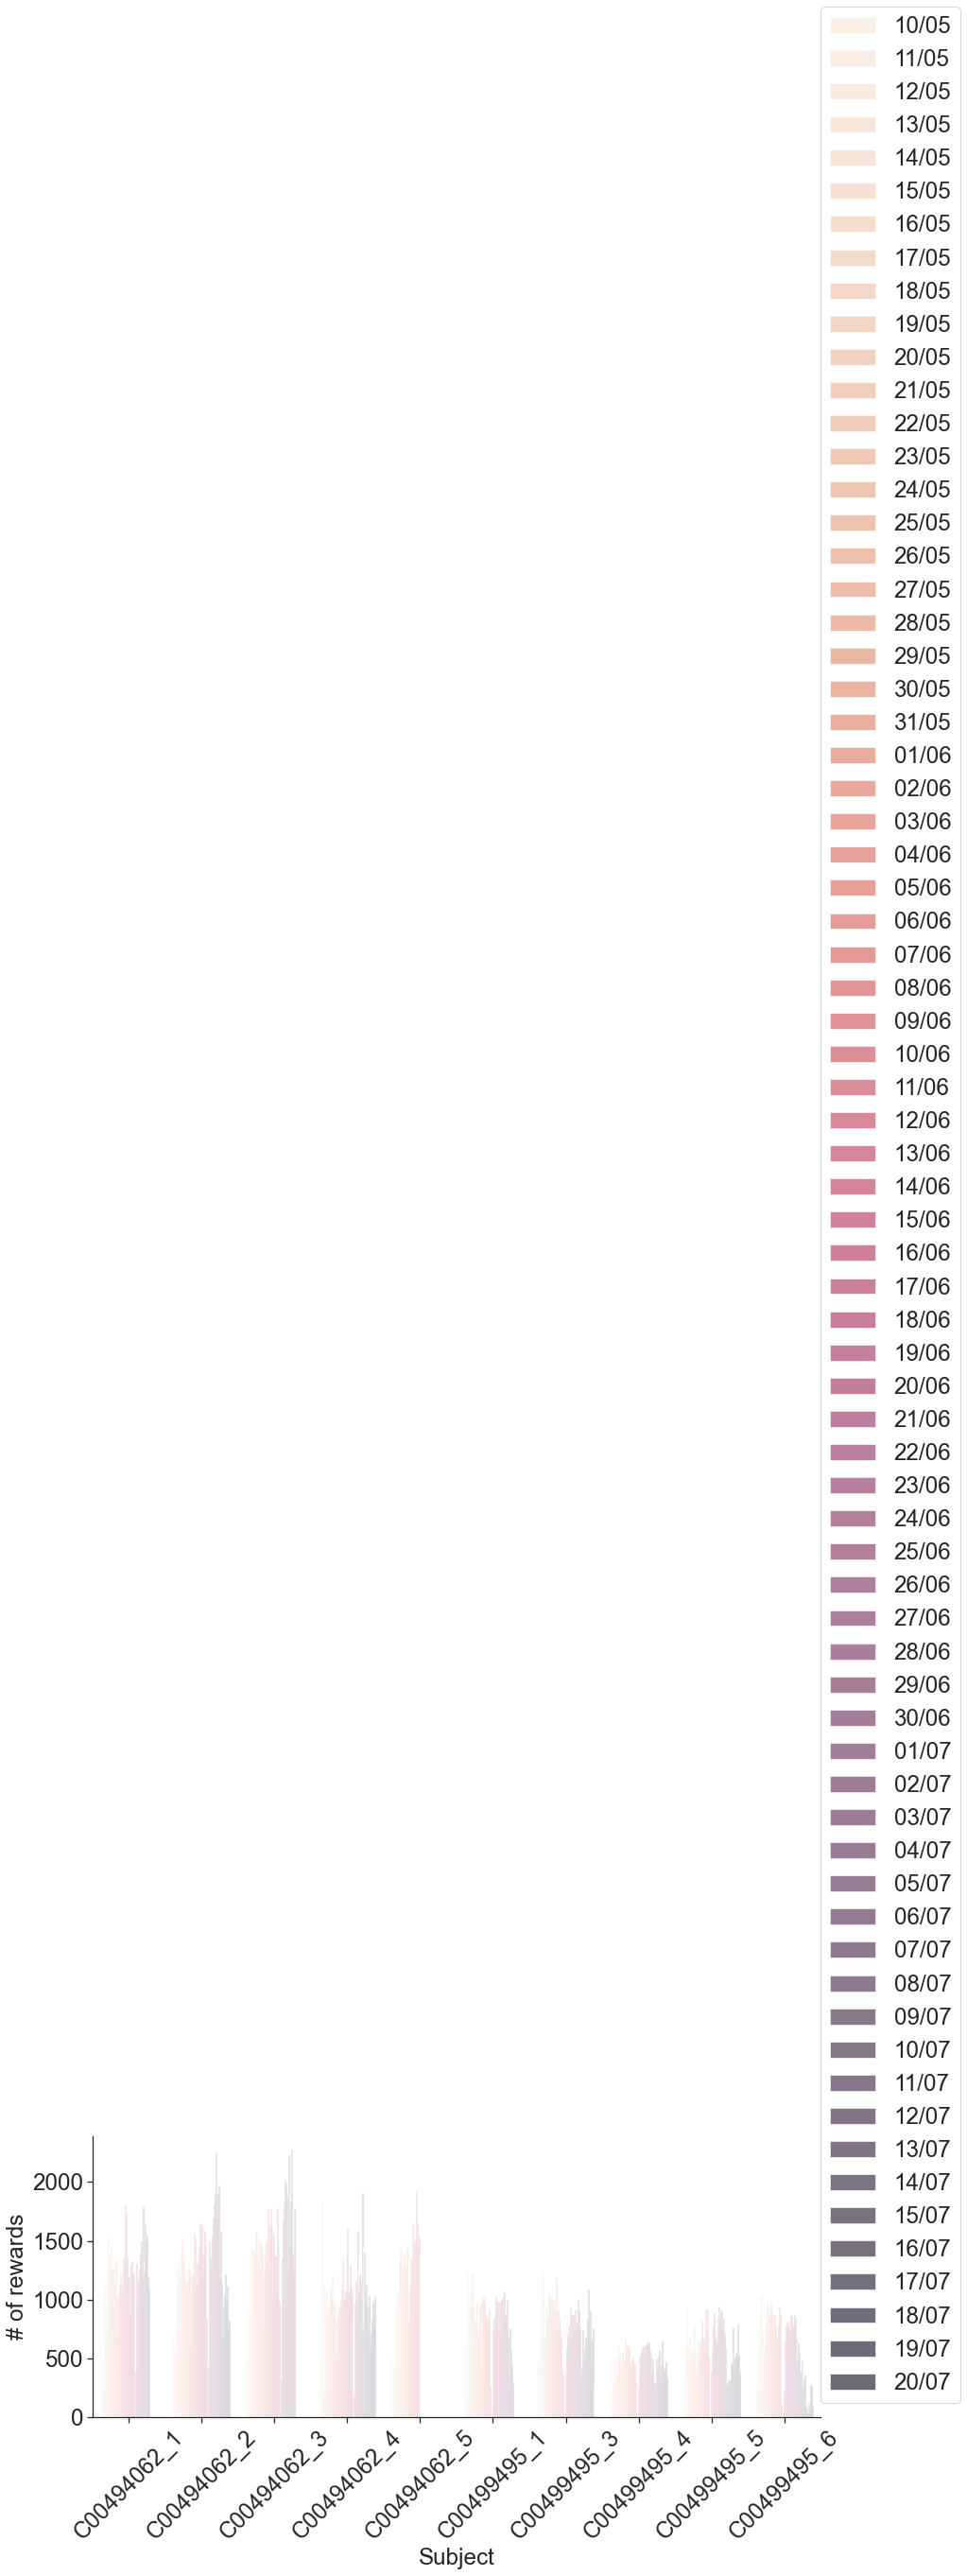

In [254]:
#plt.figure(figsize=(12,3))
g = seaborn.catplot(
    data=gbd_dfs, kind="bar",
    x="subject", y="n_rewards", hue="date",
    ci="sd", alpha=.6, height=5, # make the plot 5 units high
    aspect=2.5, palette='rocket_r',legend=False
)


#g.despine(left=True)
g.set_axis_labels("Subject", "# of rewards")

g.set_xticklabels(rotation=45)
x_dates = gbd_dfs['date'].dt.strftime('%m/%d').sort_values().unique()
#_ = plt.gca().set_xticklabels(labels=x_dates, rotation=45, ha='right')
legend = plt.gca().legend(loc=(1,.05))
for l in legend.get_texts():
    l.set_text(datetime.strptime(l.get_text()[:10],'%Y-%m-%d').strftime('%d/%m'))
#g.legend.set_title("")


<ipython-input-135-7566a8245571>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['time'] = df2['date'].dt.time


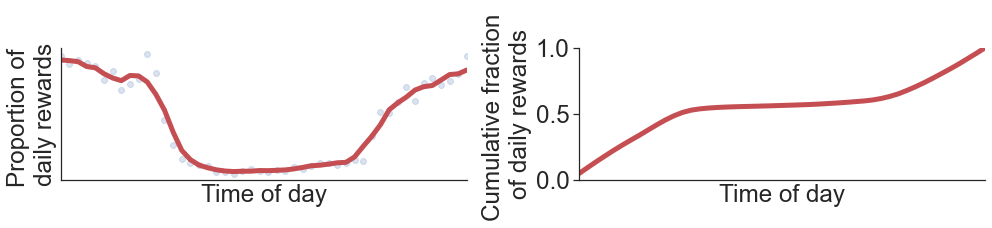

In [135]:
plt.figure(figsize=(14,2.75))
cont_running = datetime(2021, 5, 15, 12,0, 00, 0)
#cont_running = datetime.now()-timedelta(hours=18)

df2 = df.loc[#(df['date'].dt.date.astype(str) == '2021-05-11') | (df['date'].dt.date.astype(str) == '2021-05-12') |
            (df['date']>cont_running)]
#df2 = df.loc[(df['date'].dt.date.astype(str) == '2021-05-12') | 
#             (df['date'].dt.date.astype(str) == '2021-05-12')]

df2['time'] = df2['date'].dt.time
s = (df2.date - df2.date.dt.normalize()).dt.floor('30T')


#df2.groupby(df2["date"].dt.minute)["n_rewards"].sum().plot()
plt.subplot(1,2,1)
(df2.groupby(s)['n_rewards'].sum()/10.).plot(marker='o',linewidth=0,alpha=.2)
(df2.groupby(s)['n_rewards'].sum().rolling(5,min_periods=1,center=True).mean()/10.).plot(linewidth=5,color=sns.color_palette()[3])
##plt.gca().locator_params('x',nbins=12)
plt.yticks([],[])


#labels = [item.get_text()[7:] for item in plt.gca().get_xticklabels()]
#plt.gca().set_xticklabels(labels)
plt.xlabel("Time of day")
plt.ylabel("Proportion of \ndaily rewards")
plt.xticks([],[])

plt.subplot(1,2,2)
rew_per_subject = (df2.groupby(s)['n_rewards'].sum().rolling(5,min_periods=1,center=True).mean()/10.)
#plt.fill_betweenx([0,1],[6,12])
cum_rew = np.cumsum(rew_per_subject)/np.sum(rew_per_subject)
cum_rew.plot(linewidth=5,color=sns.color_palette()[3])
plt.xticks([],[])
plt.ylim(0,1)

#plt.gca().set_xticklabels(labels)
#plt.locator_params
#plt.grid()

plt.xlabel("Time of day")
plt.ylabel("Cumulative fraction \nof daily rewards")

plt.tight_layout()
seaborn.despine()
save_figure("Timing of rewards")

<ipython-input-133-434064aa7180>:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2['time'] = df2['date'].dt.time


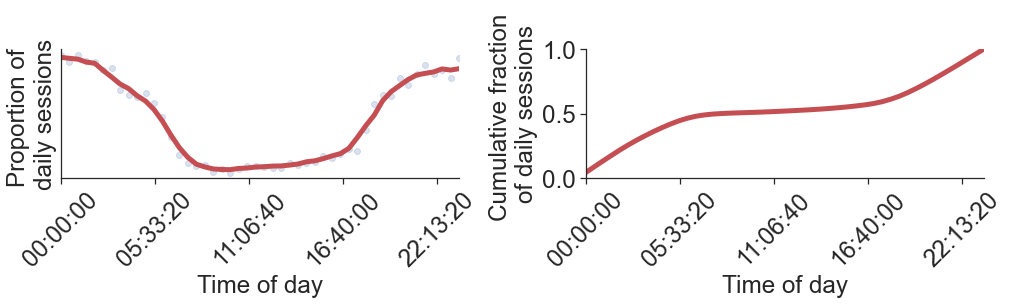

In [133]:
plt.figure(figsize=(14,4))
cont_running = datetime(2021, 5, 15, 12,0, 00, 0)
#cont_running = datetime.now()-timedelta(hours=18)

df2 = df.loc[#(df['date'].dt.date.astype(str) == '2021-05-11') | (df['date'].dt.date.astype(str) == '2021-05-12') |
            (df['date']>cont_running)]
#df2 = df.loc[(df['date'].dt.date.astype(str) == '2021-05-12') | 
#             (df['date'].dt.date.astype(str) == '2021-05-12')]

df2['time'] = df2['date'].dt.time
s = (df2.date - df2.date.dt.normalize()).dt.floor('30T')


#df2.groupby(df2["date"].dt.minute)["n_rewards"].sum().plot()
plt.subplot(1,2,1)
(df2.groupby(s)['n_rewards'].count()/10.).plot(marker='o',linewidth=0,alpha=.2)
(df2.groupby(s)['n_rewards'].count().rolling(5,min_periods=1,center=True).mean()/10.).plot(linewidth=5,color=sns.color_palette()[3])
##plt.gca().locator_params('x',nbins=12)


#labels = [item.get_text()[7:] for item in plt.gca().get_xticklabels()]
#plt.gca().set_xticklabels(labels)
plt.xlabel("Time of day")
plt.ylabel("Proportion of \ndaily sessions")
plt.xticks(rotation=45)
plt.yticks([],[])

plt.subplot(1,2,2)
rew_per_subject = (df2.groupby(s)['n_rewards'].count().rolling(5,min_periods=1,center=True).mean()/10.)
#plt.fill_betweenx([0,1],[6,12])
cum_rew = np.cumsum(rew_per_subject)/np.sum(rew_per_subject)
cum_rew.plot(linewidth=5,color=sns.color_palette()[3])
plt.xticks(rotation=45)
plt.ylim(0,1)

#plt.gca().set_xticklabels(labels)
#plt.locator_params
#plt.grid()

plt.xlabel("Time of day")
plt.ylabel("Cumulative fraction \nof daily sessions")

plt.tight_layout()
seaborn.despine()
save_figure("Timing of sessions")